In [1]:
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
import mpld3
mpld3.enable_notebook()
from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [3]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [4]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [5]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

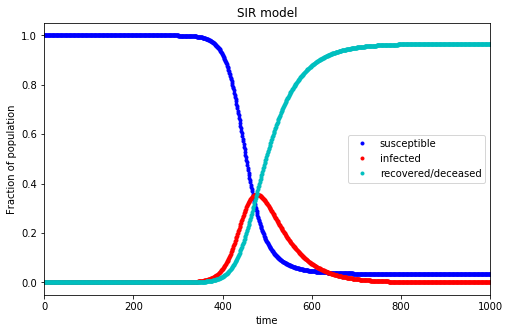

In [8]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

In [18]:
TodaysData_Country = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')

TodaysData_Country.head()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered,Incident_Rate,People_Tested,People_Hospitalized,Province_State,FIPS,UID,iso3,Report_Date_String
0,Afghanistan,1/22/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/22
1,Afghanistan,1/23/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/23
2,Afghanistan,1/24/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/24
3,Afghanistan,1/25/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/25
4,Afghanistan,1/26/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/26


In [19]:
TodaysData_Country = TodaysData_Country[TodaysData_Country['Province_State'].isnull()]
TodaysData_Country = TodaysData_Country.query('Country_Region=="US"' )
ColumnToClean = ['Confirmed', 'Deaths', 'Recovered', 'Active']
# filling missing values 
TodaysData_Country[['Country_Region']] = TodaysData_Country[['Country_Region']].fillna('')
TodaysData_Country[ColumnToClean] = TodaysData_Country[ColumnToClean].fillna(0)
TodaysData_Country = TodaysData_Country.drop([ 'Country_Region','Last_Update','Delta_Recovered','Incident_Rate','People_Tested','People_Hospitalized','Province_State','FIPS','UID','iso3'], axis=1) 
#TodaysData_Country['Report_Date_String'] = pd.to_datetime(TodaysData_Country['Report_Date_String'],"%Y-%m-%d")
TodaysData_Country.head()


,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Report_Date_String
26274,1,0,0.0,0.0,0.0,2020/01/22
26275,1,0,0.0,0.0,0.0,2020/01/23
26276,2,0,0.0,0.0,1.0,2020/01/24
26277,2,0,0.0,0.0,0.0,2020/01/25
26278,5,0,0.0,0.0,3.0,2020/01/26


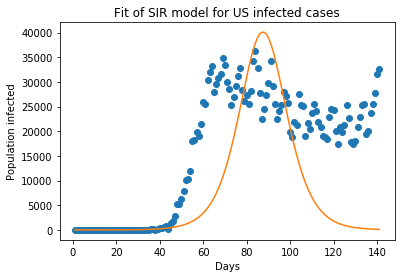

Optimal parameters: beta = 8.929022302002823  and gamma =  8.790363368798587


In [20]:
population = float(331002651) # US population
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = TodaysData_Country.Confirmed.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for US infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

New Compartments
We need to add more compartments to make the model closer to real world. 
Exposed - First compartment we need to add is exposed compartment. Since people need to be exposed to a infected person then only they will get infected. So now we need to consider SEIR model.
Dead – When we are modeling a deadly disease we need to account for death so we need to add a new compartment into our model.
Hospitalized - we need to consider the hospitalized compartment since lot factors related to this need to be added 
N: total population
S(t): number of people susceptible on day t
E(t): number of people exposed on day t
I(t): number of people infected on day t
R(t): number of people recovered on day t
D(t): number of people dead on day t
β: expected amount of people an infected person infects per day
D: number of days an infected person has and can spread the disease
γ: the proportion of infected recovering per day (γ = 1/D)
R₀: the total number of people an infected person infects (R₀ = β / γ)
δ: length of incubation period
α: fatality rate
ρ: rate at which people die (= 1/days from infected until death)
R₀_start (parameter in R₀(t))
R₀_end (parameter in R₀(t))
x₀ (parameter in R₀(t))
k (parameter in R₀(t))
s (parameter in Beds(t))
Beds₀ (parameter in R₀(t))
p(I→H): probability of going from infected to Hospitalized based on hospitalization rate
p(H→D): probability of dying in hospital based on mortality rate

In [3]:
owid_covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv',parse_dates=["date"], skiprows=[1])
owid_covid_data = owid_covid_data.query('location=="United States"' )
Data_To_Process =pd.DataFrame(columns=['date','deaths','cases'], data=owid_covid_data[['date', 'total_deaths','total_cases']].values)
Data_To_Process = Data_To_Process.sort_values(by='date', ascending=False)
Data_To_Process["deaths"] = Data_To_Process['deaths'].astype(str).astype(float)
data = Data_To_Process["deaths"].values[::-1]

In [4]:
# parameters
gamma = 1.0/9.0
sigma = 1.0/3.0
Predict_For = 30
#US Population
N = 331002647
#Data from OWID Data
beds_per_100k = 34.7

params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 180), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_H": (0.05, 0.01, 0.1), "prob_H_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [5]:
def Calculate_SEIHRD(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Hospital_Beds):
    S, E, I, H, R, D = y

    suspected = -beta(t) * I * S / N
    exposed = beta(t) * I * S / N - sigma * E
    infected = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    hosipitalized = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Hospital_Beds(t), H) - max(0, H-Hospital_Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Hospital_Beds(t), H)
    Recovered = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Hospital_Beds(t), H)
    Death = 1/7.5 * p_C_to_D * min(Hospital_Beds(t), H) + max(0, H-Hospital_Beds(t))
    return suspected, exposed, infected, hosipitalized, Recovered, Death

In [6]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [7]:
def SEIHRDModel(days, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_H, prob_H_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
  
    
    def Hospital_Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    #Solve Differential Equations with ODEINT
    ret = odeint(Calculate_SEIHRD, y0, t, args=(beta, gamma, sigma, N, prob_I_to_H, prob_H_to_D, Hospital_Beds))
    S, E, I, H, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, H, R, D, R_0_over_time, Hospital_Beds, prob_I_to_H, prob_H_to_D

In [8]:
days = Predict_For + len(data)
y_data = np.concatenate((np.zeros(Predict_For), data))

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [9]:

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_H, prob_H_to_D, s):
    ret = SEIHRDModel(days, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_H, prob_H_to_D, s)
    return ret[6][x]

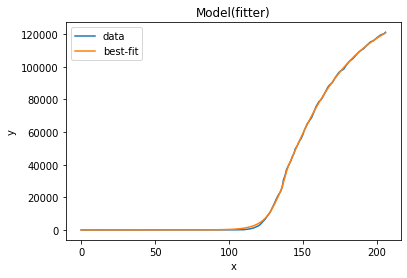

In [11]:

mod = lmfit.Model(fitter)
#The special syntax kwargs in function definitions in python is used to pass a keyworded, variable-length argument list.
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"
result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.plot_fit(datafmt="-");